In [1]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName="Loganalysis")

In [2]:
import re
import datetime

from pyspark.sql import Row

### 1- Apache Web Server Log file format

#### Parsing log file

In [3]:
month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

In [4]:
def parse_apache_time(s):
    ''' Returns apache time format to python format
    Args (time): string of apache time in the format [day/month/year:hour:minute:second timezone]
    Returns : datetime object in python format
    '''
    
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))

In [5]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [6]:
def parseapachelogline(logline):
    
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    
    if match is None:
        return (logline, 0) # this will help to debug invalid log lines
    
    size_field = match.group(9)
    if size_field == '-':
        size = float(0)
    else:
        size = float(match.group(9))
    
    return (Row(
    host          = match.group(1),
    client_identd = match.group(2),
    user_id       = match.group(3),
    date_time     = parse_apache_time(match.group(4)),
    method        = match.group(5),
    endpoint      = match.group(6),
    protocol      = match.group(7),
    response_code = int(match.group(8)),
    content_size  = size), 1)
    

In [7]:
def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile('access_log_Aug95.txt') #load file
                   .map(parseapachelogline) #parse file
                   .cache()) #cache parsed logs

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1) #filter if log line is valid
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0) #filter if log line is invalid
                   .map(lambda s: s[0]))
    
    failed_logs_count = failed_logs.count() #count of invalid log lines
    
    if failed_logs_count > 0: #print invalid log lines
        print('Number of invalid logline: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print ('Invalid logline: %s' % line)

    print ('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())) #print summary of parsing
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 895
Invalid logline: 198.213.130.253 - - [03/Aug/1995:11:29:02 -0400] "GET /shuttle/missions/sts-34/mission-sts-34.html"><IMG images/ssbuv1.gif SRC="images/small34p.gif/ HTTP/1.0" 404 -
Invalid logline: ztm-13.dial.xs4all.nl - - [04/Aug/1995:09:34:52 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: pc32.cis.uoguelph.ca - - [04/Aug/1995:10:57:21 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: sgate08.st-and.ac.uk - - [04/Aug/1995:17:52:59 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 6858
Invalid logline: userp2.snowhill.com - - [05/Aug/1995:14:57:06 -0400] "GET / " HTTP/1.0" 200 7034
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:45:33 -0400] "GET /shuttle/missions/sts-69/images/images.html 40,207 89,234 HTTP/1.0" 200 2443
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:47:52 -0400] "GET /shuttle/countdown/tour.html 40,243 89,262 HTTP/1.0" 200 4347
Invalid logline: client-71-162.online.apple.com - - [05/Aug/1995:22:53:19

In [8]:
# there are 895 invalid log lines, there is need to improve the regex
# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)\s*?(\S+)\s*?(\S+).+?".+?(\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 1
Invalid logline: titan - - [31/Aug/1995:05:06:15 -0400] "?" 400 -
Read 1569898 lines, successfully parsed 1569897 lines, failed to parse 1 lines


### 2- Sample Analyses on the Web Server Log File

#### statistics based on the content size

In [9]:
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print ('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))

Content Size Avg: 17089, Min: 0, Max: 3421948.0


#### Response Code to Count with pie chart plot

In [10]:
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code,1))
                       .reduceByKey(lambda a, b: a+b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print ('Found %d response codes' % len(responseCodeToCountList))
print ('Response Code Counts: %s' % responseCodeToCountList)

Found 8 response codes
Response Code Counts: [(200, 1398988), (400, 9), (500, 3), (501, 27), (302, 26497), (403, 171), (304, 134146), (404, 10056)]


In [11]:
labels = responseCodeToCount.map(lambda v: v[0]).collect()
count  = access_logs.count()
fracs  = responseCodeToCount.map(lambda v: v[1]/count).collect()

In [12]:
labels, count, fracs

([200, 400, 500, 501, 302, 403, 304, 404],
 1569897,
 [0.8911336221420896,
  5.732860181273039e-06,
  1.9109533937576797e-06,
  1.7198580543819117e-05,
  0.016878177358132414,
  0.00010892434344418774,
  0.08544891798633923,
  0.006405515775875742])

1
2
3
5


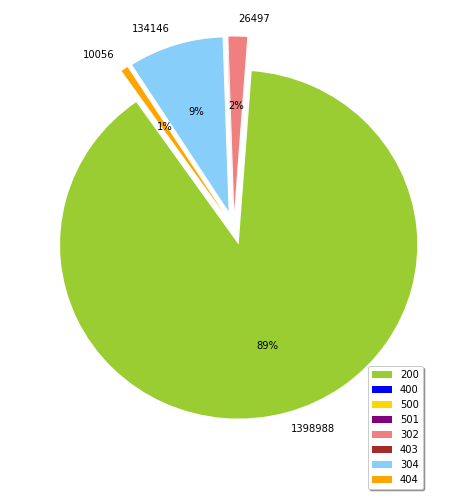

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 0.5 else '%.0f%%' % value

fig = plt.figure(figsize=(8,8), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'blue', 'gold', 'purple', 'lightcoral', 'brown', 'lightskyblue','orange']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0, 0.1, 0.1)
patches, texts, autotexts = plt.pie(fracs, labels=countlist, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)

for text, (ix,autotext) in zip(texts, enumerate(autotexts)):
    if autotext.get_text() == '':
        print(ix)
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

#### Frequent Hosts

In [14]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

In [15]:
print('Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20)


Any 20 hosts that have accessed more then 10 times: ['130.18.192.84', '204.212.234.222', 'h192_146_129_28.gte.com', '163.205.162.64', 'ad07-014.compuserve.com', 'internet22.cybersmith.com', '192.85.230.189', '192.87.211.21', 'wwhite.seanet.com', 'kuts4p02.cc.ukans.edu', 'srv1s11.saglac.qc.ca', 'quimica.biol.unlp.edu.ar', 'hickoryhill.com', '204.96.24.5', 'c128003_p6.mc.duke.edu', '134.175.8.3', '198.151.175.176', 'w20-575-76.mit.edu', 'ix-sea5-19.ix.netcom.com', '134.68.223.1']


#### Visualizing Endpoints

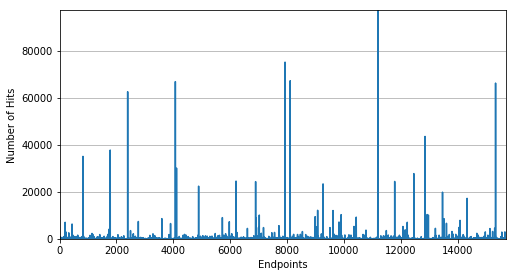

In [16]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda x: x[0]).collect()
counts = endpoints.map(lambda x: x[1]).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

#### Top Endpoints

In [17]:
print('Top endpoints are: %s'%endpoints.takeOrdered(20, lambda x: -x[1]))

Top endpoints are: [('/images/NASA-logosmall.gif', 97293), ('/images/KSC-logosmall.gif', 75283), ('/images/MOSAIC-logosmall.gif', 67356), ('/images/USA-logosmall.gif', 66975), ('/images/WORLD-logosmall.gif', 66351), ('/images/ksclogo-medium.gif', 62670), ('/ksc.html', 43619), ('/history/apollo/images/apollo-logo1.gif', 37806), ('/images/launch-logo.gif', 35119), ('/', 30121), ('/images/ksclogosmall.gif', 27789), ('/shuttle/missions/sts-69/mission-sts-69.html', 24592), ('/shuttle/countdown/', 24445), ('/shuttle/missions/sts-69/count69.gif', 24363), ('/shuttle/missions/sts-69/sts-69-patch-small.gif', 23391), ('/shuttle/missions/missions.html', 22429), ('/images/launchmedium.gif', 19863), ('/htbin/cdt_main.pl', 17238), ('/shuttle/countdown/images/countclock.gif', 12154), ('/icons/menu.xbm', 12128)]


### 3- Analyzing Web Server Log File

#### Top Ten Error Endpoints

In [18]:
not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b : a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten failed URLs: %s' % topTenErrURLs)

Top Ten failed URLs: [('/images/NASA-logosmall.gif', 19080), ('/images/KSC-logosmall.gif', 11328), ('/images/MOSAIC-logosmall.gif', 8617), ('/images/USA-logosmall.gif', 8565), ('/images/WORLD-logosmall.gif', 8360), ('/images/ksclogo-medium.gif', 7722), ('/history/apollo/images/apollo-logo1.gif', 4355), ('/shuttle/countdown/images/countclock.gif', 4227), ('/images/launch-logo.gif', 4178), ('/', 3605)]


#### Number of Unique Hosts

In [19]:
hosts = access_logs.map(lambda log: (log.host, 1))

uniqueHosts = hosts.reduceByKey(lambda a, b : a + b)

uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 75060


#### Number of Unique Hosts per day

In [20]:
dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day, log.host))

dayGroupedHosts = dayToHostPairTuple.combineByKey(lambda v: [v], lambda c, v: c + [v], lambda c1, c2: c1 + c2)

dayHostCount = dayGroupedHosts.map(lambda x: (x[0], len(set(x[1]))))
                                                   
dailyHosts = dayHostCount.sortByKey().cache()

dailyHostsList = dailyHosts.take(30)
print ('Unique hosts per day: %s' % dailyHostsList)

Unique hosts per day: [(1, 2582), (3, 3222), (4, 4191), (5, 2502), (6, 2538), (7, 4108), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2865), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4135), (22, 4456), (23, 4368), (24, 4077), (25, 4407), (26, 2644), (27, 2690), (28, 4215), (29, 4826), (30, 5266), (31, 5916)]


#### Visualizing the Number of Unique Daily Hosts

In [21]:
daysWithHosts = dailyHosts.map(lambda x: x[0]).collect()
hosts = dailyHosts.map(lambda x: x[1]).collect()

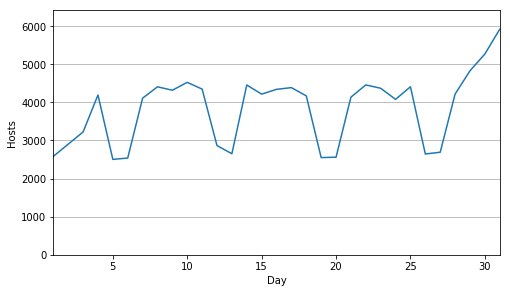

In [22]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)

#### Average Number of Daily Requests per Hosts with visualization

In [23]:
sortedByDay = dayGroupedHosts.sortByKey(ascending=True)
avgDailyReqPerHost = sortedByDay.map(lambda x: (x[0],len(x[1])/len(set(x[1])))).cache()

avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print('Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList)

Average number of daily requests per Hosts is [(1, 13.166537567776917), (3, 12.845437616387336), (4, 14.210689572894298), (5, 12.747002398081534), (6, 12.77383766745469), (7, 13.9634858812074), (8, 13.653427144802542), (9, 14.00463284688441), (10, 13.541454786646032), (11, 14.092498849516797), (12, 13.288307155322862), (13, 13.766037735849057), (14, 13.443646160754378), (15, 13.964641670621736), (16, 13.0536866359447), (17, 13.452223489167617), (18, 13.494721689059501), (19, 12.585882352941177), (20, 12.876171875), (21, 13.4316807738815), (22, 12.962746858168762), (23, 13.300595238095237), (24, 12.889870002452783), (25, 13.006807351940095), (26, 11.954614220877458), (27, 12.20185873605948), (28, 13.166310794780546), (29, 14.087857438872772), (30, 15.313520698822636), (31, 15.23394185260311)]


In [24]:
daysWithAvg = avgDailyReqPerHost.map(lambda x: x[0]).collect()
avgs = avgDailyReqPerHost.map(lambda x: x[1]).collect()

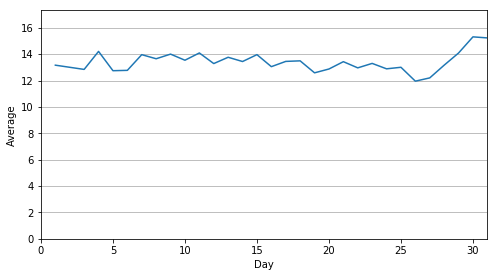

In [25]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)

### 4- Exploring 404 Response Codes

#### Counting 404 Response Codes

In [26]:
badRecords = (access_logs
              .filter(lambda log: log.response_code == 404)
              .cache())
print ('Found %d 404 URLs' % badRecords.count())

Found 10056 404 URLs


#### Listing 404 Response Code Records

In [27]:
badEndpoints = badRecords.map(lambda log: log.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print('404 URLS: %s' % badUniqueEndpointsPick40)

404 URLS: ['/ad/sponsors/starwave/sbad2.gif', '/history/apollo/sa-9/movies/', '/shutttle/missions/sts-70/images/KSC-95EC-1059.jpg', '/shuttle/missions/sts-69/images/redball.gif', '/~adverts/isn/ad1/banner.gif', '/shuttle/missions/61-b/mission-62.html', '/www.fedworld.gov/ntis/ntishome.html', '/img/sportstalk3.gif', '/ksc.html>NASA', '/PTS/thin_strip2.gif', '/software/winvn/win/', '/mir/', '/history/a[p;;p/apollo.html', '/statistics/1995/Jul/Aug95.html', '/history/apollo/pad-abort-test-2/docs/', '/shuttle/missions/sts-67/images/k95p0381.txt', '/shuttle/technology/images/sts-airlock-small.gif', '/~pccomp/graphics/pccnlne2.gif', '/cgi-bin/WebQuery', '/shuttle/countdown/images/sat_ir_east.gif', '/Shuttle/mission.htm', '/shuttle/missions/missions.hmtl', '/software/techdoc/td-2.html', '/wsoftware/winvn/winvn.html', '/wwwicons/orange.gif', '/news/sci.space.policy/archive/sci-space-policy-19-jul-1994-17.txt', '/kscpao/status/', '/gra', '/home/whats-cool.html', '/~adverts/graphics/indxlogo.gif'

####  Listing the Top Twenty 404 Response Code Endpoints

In [28]:
badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a, b: a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, lambda s: -1 * s[1])
print('Top Twenty 404 URLs: %s' % badEndpointsTop20)

Top Twenty 404 URLs: [('/pub/winvn/readme.txt', 1337), ('/pub/winvn/release.txt', 1185), ('/shuttle/missions/STS-69/mission-STS-69.html', 682), ('/images/nasa-logo.gif', 319), ('/shuttle/missions/sts-68/ksc-upclose.gif', 251), ('/elv/DELTA/uncons.htm', 209), ('/history/apollo/sa-1/sa-1-patch-small.gif', 200), ('/://spacelink.msfc.nasa.gov', 166), ('/images/crawlerway-logo.gif', 160), ('/history/apollo/a-001/a-001-patch-small.gif', 154), ('/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 144), ('/images/Nasa-logo.gif', 85), ('/history/apollo/images/little-joe.jpg', 84), ('/shuttle/resources/orbiters/discovery.gif', 82), ('/shuttle/resources/orbiters/atlantis.gif', 80), ('/robots.txt', 78), ('/shuttle/resources/orbiters/challenger.gif', 77), ('/images/lf-logo.gif', 77), ('/elv/new01.gif', 65), ('/software/winvn/winvn.html.', 57)]


#### Listing the Top Twenty-five 404 Response Code Hosts

In [29]:
errHostsCountPairTuple = badRecords.map(lambda log: (log.host, 1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a, b: a + b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1 * s[1])
print('Top 25 hosts that generated errors: %s' % errHostsTop25)

Top 25 hosts that generated errors: [('dialip-217.den.mmc.com', 62), ('piweba3y.prodigy.com', 47), ('155.148.25.4', 44), ('maz3.maz.net', 39), ('gate.barr.com', 38), ('ts8-1.westwood.ts.ucla.edu', 37), ('204.62.245.32', 37), ('m38-370-9.mit.edu', 37), ('nexus.mlckew.edu.au', 37), ('scooter.pa-x.dec.com', 35), ('reddragon.ksc.nasa.gov', 33), ('www-c4.proxy.aol.com', 32), ('piweba5y.prodigy.com', 31), ('piweba4y.prodigy.com', 30), ('www-d4.proxy.aol.com', 30), ('internet-gw.watson.ibm.com', 29), ('163.206.104.34', 28), ('unidata.com', 28), ('spica.sci.isas.ac.jp', 27), ('www-d2.proxy.aol.com', 26), ('203.13.168.24', 25), ('203.13.168.17', 25), ('www-c2.proxy.aol.com', 23), ('www-d1.proxy.aol.com', 23), ('crl5.crl.com', 23)]


#### Listing 404 Response Codes per Day

In [30]:
errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day, 1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a, b: a + b)

errDateSorted = (errDateSum
                 .sortByKey(ascending=True)
                 .cache())

errByDate = errDateSorted.collect()
print('404 Errors by day: %s' % errByDate)

404 Errors by day: [(1, 243), (3, 304), (4, 346), (5, 236), (6, 373), (7, 537), (8, 391), (9, 279), (10, 315), (11, 263), (12, 196), (13, 216), (14, 287), (15, 327), (16, 259), (17, 271), (18, 256), (19, 209), (20, 312), (21, 305), (22, 288), (23, 345), (24, 420), (25, 415), (26, 366), (27, 370), (28, 410), (29, 420), (30, 571), (31, 526)]


#### Visualizing the 404 Response Codes by Day

In [31]:
daysWithErrors404 = errDateSorted.map(lambda x: x[0]).collect()
errors404ByDay = errDateSorted.map(lambda x: x[1]).collect()

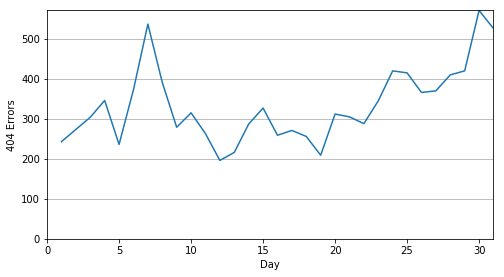

In [32]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)

#### Top Five Days for 404 Response Codes 

In [33]:
topErrDate = errDateSorted.takeOrdered(5, lambda s: -1 * s[1])
print('Top Five dates for 404 requests: %s' % topErrDate)

Top Five dates for 404 requests: [(30, 571), (7, 537), (31, 526), (24, 420), (29, 420)]


#### Hourly 404 Response Codes

In [34]:
hourCountPairTuple = badRecords.map(lambda log: (log.date_time.hour, 1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a, b: a + b)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey(ascending=True)
                     .cache())

errHourList = hourRecordsSorted.collect()
print('Top hours for 404 requests: %s' % errHourList)

Top hours for 404 requests: [(0, 344), (1, 327), (2, 600), (3, 363), (4, 183), (5, 160), (6, 135), (7, 218), (8, 340), (9, 359), (10, 492), (11, 428), (12, 651), (13, 614), (14, 522), (15, 549), (16, 550), (17, 586), (18, 425), (19, 440), (20, 432), (21, 434), (22, 430), (23, 474)]


#### Visualizing the 404 Response Codes by Hour

In [35]:
hoursWithErrors404 = hourRecordsSorted.map(lambda x: x[0]).collect()
errors404ByHours = hourRecordsSorted.map(lambda x: x[1]).collect()

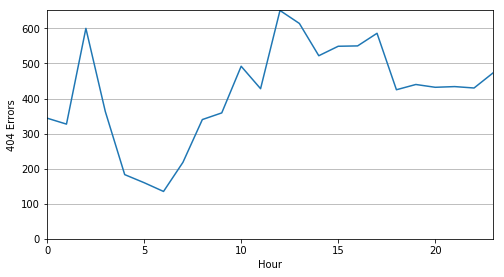

In [36]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)